# Neural Network


### Objectives
This section generates the training gathers for the neural network. The same steps are performed for the training data as for the test data, as follows:  
1. Open the `.sgy` or `.segy` file containing the gathers
2. Filter the out a certain frequency band with a bandpass filter, which will be the input gathers into the neural network.
3. Divide the gather into different (over-lapping) windows, so that there are less parameters being input into the neural network, and thus it is less demanding to run.
4. Save the windows containing the filtered gathers into X_train (input) and the unfiltered gathers into Y_train (objective).
5. The same steps are repeated for generating the test data.
6. Unnecessary windows are removed from the training data.
7. The data is normalized by the same coefficient to improve the network's performance. The new scale is from 0 to 1.
8. Finally, remaining unused variables are removed to save memory.

### Tools

In [1]:
import random
import os
import sys
import warnings
import datetime

from tqdm import tqdm

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import numpy.matlib
from numpy.fft import fft, ifft

import matplotlib.pyplot as plt

import scipy
from scipy.signal import butter, filtfilt
from scipy.stats import norm
import scipy.io

import segyio

from skimage.metrics import structural_similarity as ssim
# from skimage.measure import compare_ssim 
from skimage.metrics import peak_signal_noise_ratio as psnr



### Functions

In [2]:
#Filters to remove the 'missing' from the broadband data:

#Band-stop filter to remove the missing band
def myFilterStop(data,flp,fhi,delt):
    #c - input time series
    #flp - lowpass corner freq of filter
    #fhi - highpass corner freq
    #delt - sampling interval of the data
    
    y = data.shape[0]
    data2 = np.vstack((np.flipud(data),data,np.flipud(data)))
    slope = np.hanning(2*y).reshape((2*y,1))
    slope1 = slope[0:y]
    slope2 = np.ones((y,1))
    slope3 = slope[y:2*y]
    slope = np.vstack((slope1, slope2, slope3))

    #multiply with a nice window function
    for i in range(3*y):
        data2[i] = data2[i] * slope[i]

    n = 5 #order Butterworth filter
    fnq = 1.0 / (2*delt) #Nyquist
    Wn = [flp/fnq, fhi/fnq] #Butterworth non-dim freq
    b,a = butter(n,Wn,'bandstop',output='ba') #construct the filter
    d = filtfilt(b,a,data2,axis=0) #zero phase filter

    #pick out the part that I actually want
    d = d[1*y + 0:2*y , :]
    return d

#Band-pass filter to remove all but the missing frequency band. This was used to test the networks perforance on reconstructing
#missing frequencty data.
def myFilterPass(data,flp,fhi,delt):
    #c - input time series
    #flp - lowpass corner freq of filter
    #fhi - highpass corner freq
    #delt - sampling interval of the data
    
    y = data.shape[0]
    data2 = np.vstack((np.flipud(data),data,np.flipud(data)))
    slope = np.hanning(2*y).reshape((2*y,1))
    slope1 = slope[0:y]
    slope2 = np.ones((y,1))
    slope3 = slope[y:2*y]
    slope = np.vstack((slope1, slope2, slope3))

    #multiply with a nice window function
    for i in range(3*y):
        data2[i] = data2[i] * slope[i]

    n = 5 #order Butterworth filter
    fnq = 1.0 / (2*delt) #Nyquist
    Wn = [flp/fnq, fhi/fnq] #Butterworth non-dim freq
    b,a = butter(n,Wn,'bandpass',output='ba') #construct the filter
    d = filtfilt(b,a,data2,axis=0) #zero phase filter

    #pick out the part that I actually want
    d = d[1*y + 0:2*y , :]
    return d

#Zeroing strong filter
def myStrongFilter(data,flp,fhi,delt):
    #data - input time series
    #flp - lowpass corner freq of filter
    #fhi - highpass corner freq
    #delt - sampling interval of the data
    
    flp = flp/2
    fhi = fhi/2
    
    Fs = 1/delt
    Nyq = Nyq = Fs/2
    
    Data_Freq = fft(data,axis=0)
    Filter = np.ones(Data_Freq.shape)
    Filter[int(np.ceil((flp/Nyq)*Data_Freq.shape[0])):int(np.ceil((fhi/Nyq)*Data_Freq.shape[0])),:] = 0
    Filter[-int(np.ceil((fhi/Nyq)*Data_Freq.shape[0])):-int(np.ceil((flp/Nyq)*Data_Freq.shape[0])),:] = 0

    Data_Freq_Filt = Data_Freq*Filter
    
    return np.real(ifft(Data_Freq_Filt,axis=0))


#Two custom loss functions:

#This loss function looks into the spatially similarity of the gather.
def MyLoss(y_true, y_pred):
    
    #Compute Huber loss
    h = tf.keras.losses.Huber()
    L1 = h(y_true, y_pred)
    
    #Compute structural similarity index
    SSIM = tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
    
    return   1 - SSIM + L1


#Frequency loss function that takes the frequency data into account. 
def FreqLoss(y_true, y_pred):
    
    #Create Huber loss function
    h = tf.keras.losses.Huber()
    L1 = h(y_true, y_pred)
    
    #Cast in- and output data in complex for to perform fft
    y_true_f = tf.dtypes.cast(y_true, tf.complex64)
    y_pred_f = tf.dtypes.cast(y_pred, tf.complex64)
    
    #Compute fft
    y_true_fft = tf.signal.fft3d(y_true_f)
    y_pred_fft = tf.signal.fft3d(y_pred_f)
    
    #Compute MAE of frequency domain data
    FreqRMS = tf.math.reduce_mean(tf.abs(y_true_fft-y_pred_fft))
    
    return FreqRMS + L1


#Defining necessary layers for the neural network

#Coordinate Attention block. Taken from: https://github.com/Andrew-Qibin/CoordAttention
#This function is unused in the actual network unless uncommented
def CoordAtt(x, reduction=32, bn_trainable=False):
    def coord_act(x):
        tmpx = (ReLU(max_value=6)(x + 3)) / 6
        x = x * tmpx
        return x

    x_shape = x.shape.as_list()
    [b, h, w, c] = x_shape
    
    x_h = AveragePooling2D(pool_size=(1, w), strides=(1, 1), data_format='channels_last')(x)
    x_w = AveragePooling2D(pool_size=(h, 1), strides=(1, 1), data_format='channels_last')(x)
    x_w = K.permute_dimensions(x_w, [0, 2, 1, 3])
    
    y = concatenate(inputs=[x_h, x_w], axis=1)
    
    mip = max(8, c // reduction)
    
    y = Conv2D(filters=mip, kernel_size=(1, 1), strides=(1, 1), padding='valid')(y)
    y = BatchNormalization(trainable=bn_trainable)(y)
    y = coord_act(y)
    
    x_h, x_w = Lambda(tf.split, arguments={'axis': 1, 'num_or_size_splits': [h, w]})(y)
    
    x_w = K.permute_dimensions(x_w, [0, 2, 1, 3])
    
    a_h = Conv2D(filters=c, kernel_size=(1, 1), strides=(1, 1), padding='valid', activation="sigmoid")(x_h)
    a_w = Conv2D(filters=c, kernel_size=(1, 1), strides=(1, 1), padding='valid', activation="sigmoid")(x_w)
    
    out = x * a_h * a_w
    
    return out


#Convolution block
def conv_block(inp, num_filters):
    x = Conv2D(num_filters, (3,3), padding="same", activation="relu",kernel_initializer='HeNormal')(inp)
    x = Conv2D(num_filters, (3,3), padding="same", activation="relu",kernel_initializer='HeNormal')(x)
#     coordinate_attention = CoordAtt(x)
#     x = Add()([coordinate_attention, x])
    return x

#Encoding block
def encoder_block(inp, num_filters):
    x = conv_block(inp, num_filters) #also the skip feature
    p = MaxPooling2D((2, 2))(x) #output to the next block
    return x, p

#Decoding block
def decoder_block(inp, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (3, 3), strides=(2,2), padding="same",kernel_initializer='HeNormal')(inp)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x



### Input Paramters

In [2]:
## Parameters used in gathers:
Ntrainingsamples = 80   # Number of gathers windowed to generate training examples[-]
Ntestsamples = 1          # Number of test examples for the network to interpolate
dt = 0.004                 # Sampling rate [s]
Fs = 1/dt                  # Sampling frequency (500 Hz)
noiselevel = 0.1           # Percent noise
RandomFilts = 1            # Turn on for using 2 random 10 Hz frequency ranges
TracesPerGather = 635      # Number of traces in each gather. Default for NoSI_short is 636.

#Lower boundary of filter
flp = 20 


#Windowing Parameters:
input_width = 64         # Columns in window (space)
input_height = 512       # Rows in window (time)
overlap = 0.5            # Ratio of overlap

start_time = 0           # Where to start reading each gather incase you wish to cut off some samples
end_time = 1024          # Where to stop reading each gather. Use '-1' to select the last sample


#Network parameters
dropout = 0.0
BatchSize = 4
ValidationSplit = 0.2
Epochs = 20

## File location:
path = 'C:/Users/Ssach/OneDrive - Delft University of Technology/AGP/Thesis/Sam - Github/Sparse Solver/' 
filename = 'NoSI_200 2022-11-15 10_38_29.segy'

### Generate Training Window

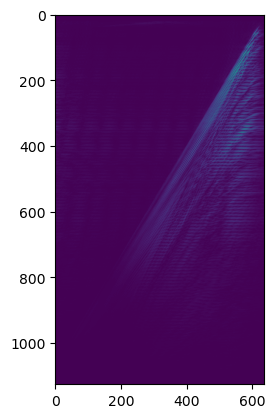

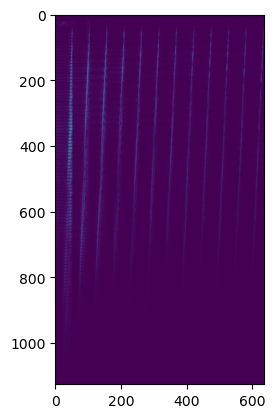

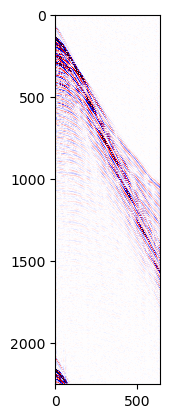

In [4]:
# Reading the Gather file and converting it into real-fk domain (using rfft will turn a gather of mxn to m/2xn) 

 ### Open Segy file using Segyio
with segyio.open(path + filename , ignore_geometry = True) as f:
    il, xl, t = f.ilines, f.xlines, f.samples
    d = segyio.tools.collect(f.trace[:])
    n_samples=d.shape[1]
    n_traces = f.tracecount

 ### Real-FFT of the gather
d_rfft = np.fft.rfft2(d)
d_rfft_amp = np.abs(d_rfft)
d_rffft_phase = np.angle(d_rfft)
plt.figure()
plt.imshow(d_rfft_amp.T)

### Sliging window

data =[]
data_rfft=[]
s=[]
e=[]
counter=0
if np.any(d) == True:
    for ii in range(0,d_rfft.shape[0],53):
            t_s = ii
            t_e = ii + 53

            s.append(t_s)
            e.append(t_e)

            window = (d[t_s:t_e,:])
            window_rfft = np.abs(np.fft.rfft2(window))
        
            data_rfft.append(window_rfft)
            data.append(window)
            t_s=ii+53


data_array = np.concatenate(data,axis=0)
data_array_rfft = np.concatenate(data_rfft,axis=0)

plt.figure()
plt.imshow(data_array_rfft.T)
plt.figure()
plt.imshow(data_array.T,cmap='seismic',vmax=10,vmin=-10)

    
    

<Figure size 640x480 with 0 Axes>

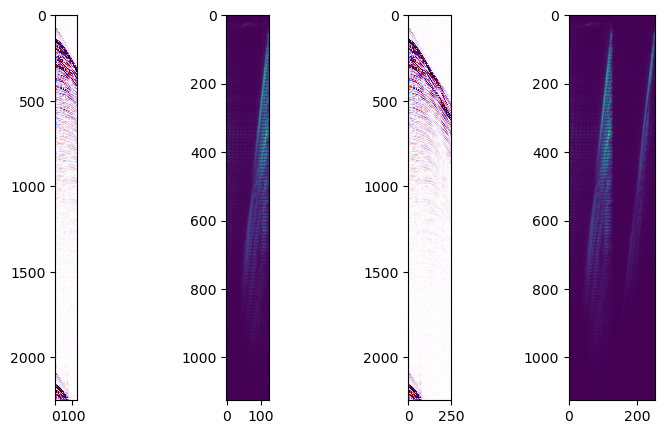

In [163]:
# Reading the Gather file and converting it into real-fk domain (using rfft will turn a gather of mxn to m/2xn) 

 ### Open Segy file using Segyio
with segyio.open(path + filename , ignore_geometry = True) as f:
    il, xl, t = f.ilines, f.xlines, f.samples
    d = segyio.tools.collect(f.trace[:])
    n_samples=d.shape[1]
    n_traces = f.tracecount

 ### Real-FFT of the gather
d_rfft = np.fft.rfft2(d)
d_rfft_amp = np.abs(d_rfft)
d_rffft_phase = np.angle(d_rfft)
plt.figure()
#plt.imshow(d_rfft_amp.T)

### Sliging window

data =[]
data_rfft=[]
s=[]
e=[]
t_s = 0
t_e = 126
window = (d[t_s:t_e,:])
window_rfft = np.abs(np.fft.rfft2(window))


t_2s = 126
t_2e = 252
window2 = (d[t_2s:t_2e,:])
window2_rfft = np.abs(np.fft.rfft2(window2))


data.append(window)
data.append(window2)
data_array = np.concatenate(data,axis=0)
data_rfft.append(window_rfft)
data_rfft.append(window2_rfft)
data_array_rfft = np.concatenate(data_rfft,axis=0)






plt.figure(figsize=(9,5))
plt.subplot(1,4,1)
plt.imshow(window.T,cmap='seismic',vmax=10,vmin=-10)
plt.subplot(1,4,2)
plt.imshow(window_rfft.T)
plt.subplot(1,4,3)
plt.imshow(data_array.T,cmap='seismic',vmax=10,vmin=-10)
plt.subplot(1,4,4)
plt.imshow(data_array_rfft.T)  
    

In [3]:
class DummyArray:
    """Dummy object that just exists to hang __array_interface__ dictionaries
    and possibly keep alive a reference to a base array.
    """

    def __init__(self, interface, base=None):
        self.__array_interface__ = interface
        self.base = base


def _maybe_view_as_subclass(original_array, new_array):
    if type(original_array) is not type(new_array):
        # if input was an ndarray subclass and subclasses were OK,
        # then view the result as that subclass.
        new_array = new_array.view(type=type(original_array))
        # Since we have done something akin to a view from original_array, we
        # should let the subclass finalize (if it has it implemented, i.e., is
        # not None).
        if new_array.__array_finalize__:
            new_array.__array_finalize__(original_array)
    return new_array

def as_strided(x, shape=None, strides=None, subok=False, writeable=True):
    x = np.array(x, copy=False, subok=subok)
    interface = dict(x.__array_interface__)
    if shape is not None:
        interface['shape'] = tuple(shape)
    if strides is not None:
        interface['strides'] = tuple(strides)

    array = np.asarray(DummyArray(interface, base=x))
    # The route via `__interface__` does not preserve structured
    # dtypes. Since dtype should remain unchanged, we set it explicitly.
    array.dtype = x.dtype

    view = _maybe_view_as_subclass(x, array)

    if view.flags.writeable and not writeable:
        view.flags.writeable = False

    return view
def sliding_window_view(x, window_shape, axis=None, *,subok=False, writeable=False):

    window_shape = (tuple(window_shape)
                    if np.iterable(window_shape)
                    else (window_shape,))
    # first convert input to array, possibly keeping subclass
    x = np.array(x, copy=False, subok=subok)

    window_shape_array = np.array(window_shape)
    if np.any(window_shape_array < 0):
        raise ValueError('`window_shape` cannot contain negative values')

    if axis is None:
        axis = tuple(range(x.ndim))
        if len(window_shape) != len(axis):
            raise ValueError(f'Since axis is `None`, must provide '
                             f'window_shape for all dimensions of `x`; '
                             f'got {len(window_shape)} window_shape elements '
                             f'and `x.ndim` is {x.ndim}.')
    else:
        axis = normalize_axis_tuple(axis, x.ndim, allow_duplicate=True)
        if len(window_shape) != len(axis):
            raise ValueError(f'Must provide matching length window_shape and '
                             f'axis; got {len(window_shape)} window_shape '
                             f'elements and {len(axis)} axes elements.')

    out_strides = x.strides + tuple(x.strides[ax] for ax in axis)

    # note: same axis can be windowed repeatedly
    x_shape_trimmed = list(x.shape)
    for ax, dim in zip(axis, window_shape):
        if x_shape_trimmed[ax] < dim:
            raise ValueError(
                'window shape cannot be larger than input array shape')
        x_shape_trimmed[ax] -= dim - 1
    out_shape = tuple(x_shape_trimmed) + window_shape
    return as_strided(x, strides=out_strides, shape=out_shape,
                      subok=subok, writeable=writeable)

def sliding_window(data, sf, window, step=None, axis=-1):
    from numpy.lib.stride_tricks import as_strided

    assert axis <= data.ndim, "Axis value out of range."
    assert isinstance(sf, (int, float)), "sf must be int or float"
    assert isinstance(window, (int, float)), "window must be int or float"
    assert isinstance(step, (int, float, type(None))), "step must be int, " "float or None."
    if isinstance(sf, float):
        assert sf.is_integer(), "sf must be a whole number."
        sf = int(sf)
    assert isinstance(axis, int), "axis must be int."

    # window and step in samples instead of points
    window *= sf
    step = window if step is None else step * sf

    if isinstance(window, float):
        assert window.is_integer(), "window * sf must be a whole number."
        window = int(window)

    if isinstance(step, float):
        assert step.is_integer(), "step * sf must be a whole number."
        step = int(step)

    assert step >= 1, "Stepsize may not be zero or negative."
    assert window < data.shape[axis], "Sliding window size may not exceed " "size of selected axis"

    # Define output shape
    shape = list(data.shape)
    shape[axis] = np.floor(data.shape[axis] / step - window / step + 1).astype(int)
    shape.append(window)

    # Calculate strides and time vector
    strides = list(data.strides)
    strides[axis] *= step
    strides.append(data.strides[axis])
    strided = as_strided(data, shape=shape, strides=strides)
    t = np.arange(strided.shape[-2]) * (step / sf)

    # Swap axis: n_epochs, ..., n_samples
    if strided.ndim > 2:
        strided = np.rollaxis(strided, -2, 0)
    return t, strided

In [22]:
with segyio.open(path + filename , ignore_geometry = True) as f:
    il, xl, t = f.ilines, f.xlines, f.samples
    d = segyio.tools.collect(f.trace[:])
    d= d[0:576,0:2048]
window_shape=(64,256)
print(d.shape)
w = sliding_window_view(d,window_shape)[::32,::128]

window = np.zeros((64,256))
data=np.zeros((64*17,15*256))
w_v = w.reshape(17*64,15*256)
w_v.shape
#sub = d-w_v
#plt.imshow(sub.T,cmap='seismic',vmax=10,vmin=-10)
#plt.colorbar()



(576, 2048)


(1088, 3840)

In [182]:
import time
import numpy
import scipy.signal
import matplotlib.pyplot as plt

In [167]:
window=sliding_window(d,size=256,stepsize=64)


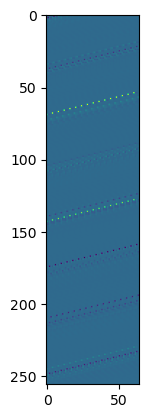

In [170]:
plt.imshow(a_strided.T)

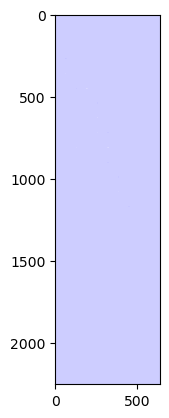

In [160]:
plt.imshow(b.T,cmap='seismic',vmax=10,vmin=-10)